<a href="https://colab.research.google.com/github/felipemontano10/DeepLearning/blob/master/PS3_JFelipeMontanoCampos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ECE 685D - Fall 2020
## Problem Set 3 

> J. Felipe Montano-Campos

**Problem 3: Binary Classification with Generalized Linear Models**


In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.linalg import inv
from sklearn import preprocessing

In [2]:
from google.colab import files
uploaded = files.upload()

Saving breast_cancer.csv to breast_cancer.csv


In [3]:
#Data Preparation 
cancer_data = pd.read_csv("breast_cancer.csv") 

targets = cancer_data["diagnosis"]
targets = targets.replace({"B": 0, "M": 1})

features = ['radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se']

features_df = cancer_data[features]

X_train, X_test, y_train, y_test = train_test_split(features_df, targets, test_size=0.3, random_state=40)




**Discriminant Analysis**

In [4]:
##Discriminant Analysis

def discriminant_binary(X_train, y_train, X_test, y_test):
    train = pd.concat([X_train, y_train], axis=1, sort=False)
    sigma =  np.cov(X_train.T)
    sigma_inv = inv(sigma)
    mu_1 = train.loc[train["diagnosis"]==1].mean() 
    mu_2 = train.loc[train["diagnosis"]==0].mean()
    mu_1 = np.array(mu_1.drop(index = "diagnosis"))
    mu_2 = np.array(mu_2.drop(index = "diagnosis"))
    p_c1 = np.mean(np.array(train["diagnosis"]))
    p_c2 = 1-p_c1
    w = np.matmul(sigma_inv,(mu_1-mu_2))
    w_0 = -0.5*np.matmul(np.matmul(mu_1.T,sigma_inv),mu_1)+ 0.5*np.matmul(np.matmul(mu_2.T,sigma_inv),mu_2)+np.log(p_c1/p_c2)
    train_pred = w_0 + np.matmul(np.array(X_train),w)
    train_pred[train_pred > 0] =1
    train_pred[train_pred < 0] = 0
    correct_train = (train_pred == y_train)
    accuracy_train = correct_train.sum() / correct_train.size
    test_pred = w_0 + np.matmul(np.array(X_test),w)
    test_pred[test_pred > 0] =1
    test_pred[test_pred < 0] = 0
    correct_test = (test_pred == y_test)    
    accuracy_test = correct_test.sum() / correct_test.size
    
    return (accuracy_test, accuracy_train)

In [5]:
test_acc, train_acc = discriminant_binary(X_train, y_train, X_test, y_test)
print("Training Accuracy:"+str(train_acc)) 
print("Test Accuracy:"+str(test_acc)) 

Training Accuracy:0.8944723618090452
Test Accuracy:0.935672514619883


**Logistic Regression**

In [7]:
#Import Packages
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#Pre Process Data
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

In [8]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim,bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out


n_epochs = 50
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_classes = y_train.value_counts().shape[0]
learning_rate = 0.1

In [9]:
#Define the Logistic Regression Function to train the model

def LR(X_train, y_train, X_test, y_test, n_epochs, n_features,n_classes,learning_rate):
    X, y = torch.from_numpy(np.array(X_train)).float(), torch.from_numpy(np.array(y_train)).long()
    Xtest, ytest = torch.from_numpy(np.array(X_test)).float(), torch.from_numpy(np.array(y_test)).long()    
    model = LogisticRegressionModel(n_features, n_classes)
    optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate) # Experiment to see the senstivity of learning rate with SGD
    criterion = nn.CrossEntropyLoss()
    # Train
    model.train('True')
    loss_train = []
    loss_test = []
    train_list = []
    test_list = []
    for epoch in range(n_epochs):
        print("Epoch number:"+str(epoch))        
        y_hat = model(X)
        loss = criterion(y_hat.squeeze(), y)
        optimizer.zero_grad()
        loss.backward() # Backward Pass
        optimizer.step()
        loss_train.append(loss.item())
        #Training Accuracy
        _, predicted = torch.max(y_hat.data,1)
        correct = (predicted == y) 
        accuracy = int(correct.sum()) / correct.shape[0]
        print("Training Accuracy")
        print(accuracy)
        train_list.append(accuracy)
        #Test Accuracy
        y_hat_test = model(Xtest)     
        losstest = criterion(y_hat_test.squeeze(), ytest)
        loss_test.append(losstest.item())
        _, predicted_test = torch.max(y_hat_test.data,1)
        correct_test = (predicted_test == ytest)    
        accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
        print("Test Accuracy")
        print(accuracy_test)
        test_list.append(accuracy_test)
    return (loss_train, loss_test ,train_list,test_list)


In [10]:
loss_train, loss_test, train_list, test_list = LR(X_train, y_train, X_test, y_test, n_epochs, n_features,n_classes,learning_rate)


Epoch number:0
Training Accuracy
0.31155778894472363
Test Accuracy
0.47368421052631576
Epoch number:1
Training Accuracy
0.41708542713567837
Test Accuracy
0.5614035087719298
Epoch number:2
Training Accuracy
0.5301507537688442
Test Accuracy
0.631578947368421
Epoch number:3
Training Accuracy
0.6206030150753769
Test Accuracy
0.695906432748538
Epoch number:4
Training Accuracy
0.678391959798995
Test Accuracy
0.7368421052631579
Epoch number:5
Training Accuracy
0.7336683417085427
Test Accuracy
0.7719298245614035
Epoch number:6
Training Accuracy
0.7763819095477387
Test Accuracy
0.7953216374269005
Epoch number:7
Training Accuracy
0.8040201005025126
Test Accuracy
0.8128654970760234
Epoch number:8
Training Accuracy
0.8241206030150754
Test Accuracy
0.8304093567251462
Epoch number:9
Training Accuracy
0.8442211055276382
Test Accuracy
0.8362573099415205
Epoch number:10
Training Accuracy
0.864321608040201
Test Accuracy
0.8421052631578947
Epoch number:11
Training Accuracy
0.8743718592964824
Test Accurac

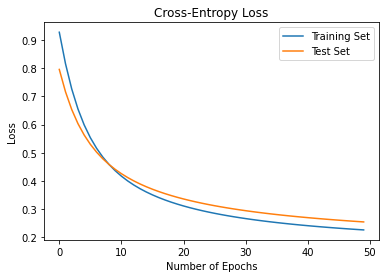

In [11]:
##Plot losses

plt.plot(list(range(n_epochs)),loss_train, label = "Training Set" )
plt.plot(list(range(n_epochs)),loss_test, label = "Test Set" )
plt.title('Cross-Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc='upper right')
plt.show()

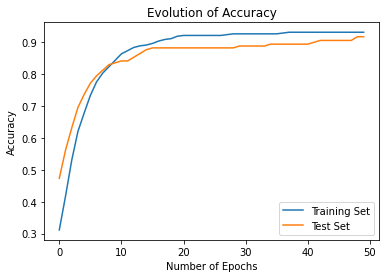

In [12]:

#Plot Accuracy
plt.plot(list(range(n_epochs)),train_list, label = "Training Set" )
plt.plot(list(range(n_epochs)),test_list, label = "Test Set" )
plt.title('Evolution of Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(loc='lower right')
plt.show()

**Problem 5: First-order Optimization Methods**

In [13]:
import scipy
import scipy.io



In [14]:
from google.colab import files
uploaded = files.upload()

Saving mnist-original.mat to mnist-original.mat


In [15]:
#import Data
mnist_data = scipy.io.loadmat('mnist-original.mat')
X = mnist_data['data'].T
y = mnist_data['label'].T
#Pre process
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
#Train and test set
train_dataset, test_dataset, train_labels, test_labels = train_test_split(X, y, test_size=1/7, random_state=671)
train_labels = pd.get_dummies(pd.DataFrame(train_labels)[0], prefix='numb')
test_labels = pd.get_dummies(pd.DataFrame(test_labels)[0], prefix='numb')
print (train_dataset.shape, train_labels.shape)
print (test_dataset.shape, test_labels.shape)
#Get everything in np.array
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
#Use Pytorch
X, y = torch.from_numpy(np.array(train_dataset)).float(), torch.from_numpy(np.array(train_labels)).long()
Xtest, ytest = torch.from_numpy(np.array(test_dataset)).float(), torch.from_numpy(np.array(test_labels)).long()


(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [16]:
#Define logistic regression
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim,bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out

**Momentum Method**

In [22]:
#Initialize Model Parameters

lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.9
n_epochs = 200      
batch_sizes = [500,60000]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w = torch.zeros((X.shape[1],y.shape[1] ))
        m_w = m_w.T
        m_b = torch.zeros(y.shape[1])
        print("LAMBDA:"+str(lambda_param))
        for epoch in list(range(n_epochs))[1:]:
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat.squeeze(), torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():  # 3
                    m_w = beta*m_w + w.grad
                    m_b = beta*m_b +b.grad
                    w -= learning_rate * m_w
                    b -= learning_rate * m_b
                #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(5*10)==0:    
                print("Epoch number:"+str(epoch+1))
                print("Test Accuracy")
                print(accuracy_test)


BATCH SIZE:500
LAMBDA:0.01
Epoch number:50
Test Accuracy
0.89
Epoch number:100
Test Accuracy
0.898
Epoch number:150
Test Accuracy
0.9019
Epoch number:200
Test Accuracy
0.9044
LAMBDA:0.1
Epoch number:50
Test Accuracy
0.8787
Epoch number:100
Test Accuracy
0.8815
Epoch number:150
Test Accuracy
0.882
Epoch number:200
Test Accuracy
0.8815
LAMBDA:1
Epoch number:50
Test Accuracy
0.7219
Epoch number:100
Test Accuracy
0.6768
Epoch number:150
Test Accuracy
0.7196
Epoch number:200
Test Accuracy
0.647
BATCH SIZE:60000
LAMBDA:0.01
Epoch number:50
Test Accuracy
0.6321
Epoch number:100
Test Accuracy
0.7471
Epoch number:150
Test Accuracy
0.7808
Epoch number:200
Test Accuracy
0.7977
LAMBDA:0.1
Epoch number:50
Test Accuracy
0.6254
Epoch number:100
Test Accuracy
0.7342
Epoch number:150
Test Accuracy
0.7695
Epoch number:200
Test Accuracy
0.786
LAMBDA:1
Epoch number:50
Test Accuracy
0.6346
Epoch number:100
Test Accuracy
0.7418
Epoch number:150
Test Accuracy
0.7685
Epoch number:200
Test Accuracy
0.7748


In [26]:
#Initialize Model Parameters

lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.9
n_epochs = 2      
batch_sizes = [1]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w = torch.zeros((X.shape[1],y.shape[1] ))
        m_w = m_w.T
        m_b = torch.zeros(y.shape[1])
        print("LAMBDA:"+str(lambda_param))
        for epoch in list(range(n_epochs))[1:]:
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat, torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():  # 3
                    m_w = beta*m_w + w.grad
                    m_b = beta*m_b +b.grad
                    w -= learning_rate * m_w
                    b -= learning_rate * m_b
                #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(1)==0:    
                print("Epoch number:"+str(epoch+1))
                print("Test Accuracy")
                print(accuracy_test)

BATCH SIZE:1
LAMBDA:0.01
Epoch number:2
Test Accuracy
0.8877
LAMBDA:0.1
Epoch number:2
Test Accuracy
0.8671
LAMBDA:1
Epoch number:2
Test Accuracy
0.4762


**NAG Method**

In [23]:
lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.95
n_epochs = 200    
batch_sizes = [500,60000]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w = torch.zeros((X.shape[1],y.shape[1] ))
        m_w = m_w.T
        m_b = torch.zeros(y.shape[1]) 
        print("LAMBDA:"+str(lambda_param))
        for epoch in list(range(n_epochs))[1:]:
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                w = list(model.parameters())[0]
                b = list(model.parameters())[1]
                w = w +beta*m_w
                b = b +beta*m_b
                y_hat = model(batch_x)
                w_fake = list(model.parameters())[0]
                b_fake = list(model.parameters())[1]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat.squeeze(), torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w_fake.grad is not None:
                    w_fake.grad.zero_()
                if b_fake.grad is not None:
                    b_fake.grad.zero_()    
                loss.backward()
                
                with torch.no_grad():  # 3
                    m_w = beta*m_w - learning_rate*w_fake.grad
                    m_b = beta*m_b - learning_rate*b_fake.grad
                    w +=  m_w
                    b +=  m_b
                #Update parameters
                model.linear.weight.data = w.clone()
                model.linear.bias.data = b.clone()
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(5*10)==0:    
                print("Epoch number:"+str(epoch+1))
                print("Test Accuracy")
                print(accuracy_test)


BATCH SIZE:500
LAMBDA:0.01
Epoch number:50
Test Accuracy
0.9039
Epoch number:100
Test Accuracy
0.9074
Epoch number:150
Test Accuracy
0.9094
Epoch number:200
Test Accuracy
0.9106
LAMBDA:0.1
Epoch number:50
Test Accuracy
0.8818
Epoch number:100
Test Accuracy
0.8807
Epoch number:150
Test Accuracy
0.8816
Epoch number:200
Test Accuracy
0.8802
LAMBDA:1
Epoch number:50
Test Accuracy
0.657
Epoch number:100
Test Accuracy
0.7273
Epoch number:150
Test Accuracy
0.6025
Epoch number:200
Test Accuracy
0.6721
BATCH SIZE:60000
LAMBDA:0.01
Epoch number:50
Test Accuracy
0.7596
Epoch number:100
Test Accuracy
0.8137
Epoch number:150
Test Accuracy
0.8324
Epoch number:200
Test Accuracy
0.8439
LAMBDA:0.1
Epoch number:50
Test Accuracy
0.769
Epoch number:100
Test Accuracy
0.8155
Epoch number:150
Test Accuracy
0.8321
Epoch number:200
Test Accuracy
0.8407
LAMBDA:1
Epoch number:50
Test Accuracy
0.7641
Epoch number:100
Test Accuracy
0.7854
Epoch number:150
Test Accuracy
0.7533
Epoch number:200
Test Accuracy
0.7355


In [27]:
lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.95
n_epochs = 2    
batch_sizes = [1]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w = torch.zeros((X.shape[1],y.shape[1] ))
        m_w = m_w.T
        m_b = torch.zeros(y.shape[1]) 
        print("LAMBDA:"+str(lambda_param))
        for epoch in list(range(n_epochs))[1:]:
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                w = list(model.parameters())[0]
                b = list(model.parameters())[1]
                w = w +beta*m_w
                b = b +beta*m_b
                y_hat = model(batch_x)
                w_fake = list(model.parameters())[0]
                b_fake = list(model.parameters())[1]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat, torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w_fake.grad is not None:
                    w_fake.grad.zero_()
                if b_fake.grad is not None:
                    b_fake.grad.zero_()    
                loss.backward()
                
                with torch.no_grad():  # 3
                    m_w = beta*m_w - learning_rate*w_fake.grad
                    m_b = beta*m_b - learning_rate*b_fake.grad
                    w +=  m_w
                    b +=  m_b
                #Update parameters
                model.linear.weight.data = w.clone()
                model.linear.bias.data = b.clone()
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(1)==0:    
                print("Epoch number:"+str(epoch+1))
                print("Test Accuracy")
                print(accuracy_test)


BATCH SIZE:1
LAMBDA:0.01
Epoch number:2
Test Accuracy
0.889
LAMBDA:0.1
Epoch number:2
Test Accuracy
0.8059
LAMBDA:1
Epoch number:2
Test Accuracy
0.5323


**RMSprop Method**

In [24]:
#Initialize Model Parameters
lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.9
gamma = 1
epsilon = 10**(-8)
n_epochs = 200     
batch_sizes = [500,60000]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        v_w = torch.zeros((X.shape[1],y.shape[1] ))
        v_w = v_w.T
        v_b = torch.zeros(y.shape[1])    
        print("LAMBDA:"+str(lambda_param))
        for epoch in list(range(n_epochs))[1:]:
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat.squeeze(), torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():  # 3
                    v_w = (1-beta)*v_w + beta*(w.grad*w.grad)
                    v_b = (1-beta)*v_b + beta*(b.grad*b.grad)
                    b_w = torch.div(gamma, epsilon + torch.sqrt(v_w)) 
                    b_b = torch.div(gamma, epsilon + torch.sqrt(v_b))
                    w -= learning_rate * (w.grad*b_w)
                    b -= learning_rate * (b.grad*b_b)
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(5*10)==0:
                print("Epoch number:"+str(epoch+1))
                print("Test Accuracy")
                print(accuracy_test)
    

BATCH SIZE:500
LAMBDA:0.01
Epoch number:50
Test Accuracy
0.9105
Epoch number:100
Test Accuracy
0.9098
Epoch number:150
Test Accuracy
0.9089
Epoch number:200
Test Accuracy
0.9095
LAMBDA:0.1
Epoch number:50
Test Accuracy
0.8777
Epoch number:100
Test Accuracy
0.8796
Epoch number:150
Test Accuracy
0.8807
Epoch number:200
Test Accuracy
0.8792
LAMBDA:1
Epoch number:50
Test Accuracy
0.6244
Epoch number:100
Test Accuracy
0.7023
Epoch number:150
Test Accuracy
0.6971
Epoch number:200
Test Accuracy
0.5893
BATCH SIZE:60000
LAMBDA:0.01
Epoch number:50
Test Accuracy
0.8183
Epoch number:100
Test Accuracy
0.8702
Epoch number:150
Test Accuracy
0.8894
Epoch number:200
Test Accuracy
0.8993
LAMBDA:0.1
Epoch number:50
Test Accuracy
0.8209
Epoch number:100
Test Accuracy
0.8652
Epoch number:150
Test Accuracy
0.8752
Epoch number:200
Test Accuracy
0.879
LAMBDA:1
Epoch number:50
Test Accuracy
0.6877
Epoch number:100
Test Accuracy
0.6578
Epoch number:150
Test Accuracy
0.6474
Epoch number:200
Test Accuracy
0.6444

In [29]:
#Initialize Model Parameters
lambdas = [0.01,0.1,1]
learning_rate = 0.001
beta = 0.9
gamma = 1
epsilon = 10**(-8)
n_epochs = 2    
batch_sizes = [1]    
    
#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        v_w = torch.zeros((X.shape[1],y.shape[1] ))
        v_w = v_w.T
        v_b = torch.zeros(y.shape[1])    
        print("LAMBDA:"+str(lambda_param))
        for epoch in list(range(n_epochs))[1:]:
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat, torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():  # 3
                    v_w = (1-beta)*v_w + beta*(w.grad*w.grad)
                    v_b = (1-beta)*v_b + beta*(b.grad*b.grad)
                    b_w = torch.div(gamma, epsilon + torch.sqrt(v_w)) 
                    b_b = torch.div(gamma, epsilon + torch.sqrt(v_b))
                    w -= learning_rate * (w.grad*b_w)
                    b -= learning_rate * (b.grad*b_b)
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (epoch+1)%(1)==0:
                print("Epoch number:"+str(epoch+1))
                print("Test Accuracy")
                print(accuracy_test)
    

BATCH SIZE:1
LAMBDA:0.01
Epoch number:2
Test Accuracy
0.7666
LAMBDA:0.1
Epoch number:2
Test Accuracy
0.7472
LAMBDA:1
Epoch number:2
Test Accuracy
0.1129


**ADAM Method**

In [25]:
#Initialize Model Parameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 10**(-8)
n_epochs = 200
lambdas = [0.01,0.1,1]
batch_sizes = [500,60000]    

#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w_1 = torch.zeros((X.shape[1],y.shape[1] ))
        m_w_1 = m_w_1.T
        m_w_2 = torch.zeros((X.shape[1],y.shape[1] ))
        m_w_2 = m_w_2.T
        m_b_1 = torch.zeros(y.shape[1])  
        m_b_2 = torch.zeros(y.shape[1])   
        print("LAMBDA:"+str(lambda_param))
        for k in list(range(n_epochs))[1:]:
            k +=1
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat.squeeze(), torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():
                    m_w_1 = beta_1*m_w_1 + (1-beta_1)*w.grad
                    m_b_1 = beta_1*m_b_1 + (1-beta_1)*b.grad
                    m_w_tilde_1 = m_w_1*(1-beta_1**(k-1))**(-1)        
                    m_b_tilde_1 = m_b_1*(1-beta_1**(k-1))**(-1)        
                    m_w_2 = beta_2*m_w_2 + (1-beta_2)*(w.grad*w.grad)
                    m_b_2 = beta_2*m_b_2 + (1-beta_2)*(b.grad*b.grad)        
                    m_w_tilde_2 = m_w_2*(1-beta_2**(k-1))**(-1)        
                    m_b_tilde_2 = m_b_2*(1-beta_2**(k-1))**(-1)      
                    w -= learning_rate*torch.div(m_w_tilde_1, epsilon + torch.sqrt(m_w_tilde_2))
                    b -= learning_rate*torch.div(m_b_tilde_1, epsilon + torch.sqrt(m_b_tilde_2))
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (k+1)%(5*10)==0:       
                print("Epoch number:"+str(k+1))
                print("Test Accuracy")
                print(accuracy_test)

BATCH SIZE:500
LAMBDA:0.01
Epoch number:50
Test Accuracy
0.9086
Epoch number:100
Test Accuracy
0.9107
Epoch number:150
Test Accuracy
0.9109
Epoch number:200
Test Accuracy
0.911
LAMBDA:0.1
Epoch number:50
Test Accuracy
0.8809
Epoch number:100
Test Accuracy
0.8813
Epoch number:150
Test Accuracy
0.8813
Epoch number:200
Test Accuracy
0.8812
LAMBDA:1
Epoch number:50
Test Accuracy
0.7131
Epoch number:100
Test Accuracy
0.6534
Epoch number:150
Test Accuracy
0.6457
Epoch number:200
Test Accuracy
0.681
BATCH SIZE:60000
LAMBDA:0.01
Epoch number:50
Test Accuracy
0.8078
Epoch number:100
Test Accuracy
0.8533
Epoch number:150
Test Accuracy
0.8716
Epoch number:200
Test Accuracy
0.881
LAMBDA:0.1
Epoch number:50
Test Accuracy
0.8102
Epoch number:100
Test Accuracy
0.8483
Epoch number:150
Test Accuracy
0.8611
Epoch number:200
Test Accuracy
0.8677
LAMBDA:1
Epoch number:50
Test Accuracy
0.764
Epoch number:100
Test Accuracy
0.7362
Epoch number:150
Test Accuracy
0.7143
Epoch number:200
Test Accuracy
0.7131


In [32]:
#Initialize Model Parameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 10**(-8)
n_epochs = 2
lambdas = [0.01,0.1,1]
batch_sizes = [1]    

#Estimation 
for batch_size in batch_sizes:
    print("BATCH SIZE:"+str(batch_size))
    for lambda_param in lambdas:
        model = LogisticRegressionModel(X.shape[1], y.shape[1])
        criterion = nn.CrossEntropyLoss()
        m_w_1 = torch.zeros((X.shape[1],y.shape[1] ))
        m_w_1 = m_w_1.T
        m_w_2 = torch.zeros((X.shape[1],y.shape[1] ))
        m_w_2 = m_w_2.T
        m_b_1 = torch.zeros(y.shape[1])  
        m_b_2 = torch.zeros(y.shape[1])   
        print("LAMBDA:"+str(lambda_param))
        for k in list(range(n_epochs))[1:]:
            k +=1
             # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            for i in range(0,X.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
                y_hat = model(batch_x)
                b = list(model.parameters())[1]
                w = list(model.parameters())[0]
                l2_regularization = torch.norm(b) + torch.norm(w)
                loss = criterion(y_hat, torch.max(batch_y, 1)[1]) + lambda_param*l2_regularization
                if w.grad is not None:
                    w.grad.zero_()
                if b.grad is not None:
                    b.grad.zero_()
                loss.backward()
                with torch.no_grad():
                    m_w_1 = beta_1*m_w_1 + (1-beta_1)*w.grad
                    m_b_1 = beta_1*m_b_1 + (1-beta_1)*b.grad
                    m_w_tilde_1 = m_w_1*(1-beta_1**(k-1))**(-1)        
                    m_b_tilde_1 = m_b_1*(1-beta_1**(k-1))**(-1)        
                    m_w_2 = beta_2*m_w_2 + (1-beta_2)*(w.grad*w.grad)
                    m_b_2 = beta_2*m_b_2 + (1-beta_2)*(b.grad*b.grad)        
                    m_w_tilde_2 = m_w_2*(1-beta_2**(k-1))**(-1)        
                    m_b_tilde_2 = m_b_2*(1-beta_2**(k-1))**(-1)      
                    w -= learning_rate*torch.div(m_w_tilde_1, epsilon + torch.sqrt(m_w_tilde_2))
                    b -= learning_rate*torch.div(m_b_tilde_1, epsilon + torch.sqrt(m_b_tilde_2))
            #Test Accuracy
            y_hat_test = model(Xtest)     
            _, predicted_test = torch.max(y_hat_test.data,1)
            correct_test = (predicted_test == torch.max(ytest, 1)[1])    
            accuracy_test = int(correct_test.sum()) / correct_test.shape[0]
            if (k+1)%(1)==0:       
                print("Epoch number:"+str(k+1))
                print("Test Accuracy")
                print(accuracy_test)

BATCH SIZE:1
LAMBDA:0.01
Epoch number:3
Test Accuracy
0.9028
LAMBDA:0.1
Epoch number:3
Test Accuracy
0.8674
LAMBDA:1
Epoch number:3
Test Accuracy
0.3633
